# 1.Tổng quan

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import datetime

from time import time
from lightgbm import LGBMModel,LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler,AllKNN
from sklearn.model_selection import train_test_split 
from sklearn import datasets, metrics, model_selection
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,roc_auc_score
from sklearn.model_selection import KFold, TimeSeriesSplit

In [ ]:
train_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
train_trans = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
test_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
test_trans = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')

In [ ]:
print('Train_identity: ', train_id.shape)
print('Train_transaction: ', train_trans.shape)
print('Test_identity: ',test_id.shape)
print('Test_transaction: ', test_trans.shape)

## Merge 2 tập Transaction và Identity
Do 2 loại dữ liệu đều chung trường Transaction ID, nên em quyết định sẽ merge 2 tập với nhau, dùng Transaction ID làm key dùng kiểu join right

In [ ]:
train = pd.merge(train_id,train_trans,left_on='TransactionID',right_on='TransactionID',how='right')
test = pd.merge(test_id,test_trans,left_on='TransactionID',right_on='TransactionID',how='right')
train.head()

In [ ]:
del train_id
del train_trans
del test_id
del test_trans
gc.collect()

# 2.Tiền xử lý dữ liệu

## Giảm kích cỡ dữ liệu
Các giá trị trong tập dữ liệu chưa được lưu ở kiểu tối ưu nhất, gây khó khăn trong quá trình chạy mô hình. 

=> Vì thế ta sẽ xử lý vấn đề này bằng cách đổi kiểu dữ liệu

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

## Fill NaN
Bên cạnh đó, lượng dữ liệu trong bảng thiếu hụt rất nhiều. Tuy nhiên 2 model XGB và LGBM đều tự xử lí được vấn đề này, vì thế ta sẽ fill NaN với -999 (để tránh trùng với các giá trị trong cột)

In [ ]:
train_y = train['isFraud']
train = train.drop(columns=['isFraud'])

train = train.fillna(-999)
test = test.fillna(-999)
train.head()

## Label Encoder
Các giá trị trong bảng vẫn tồn tại cả kiểu số lẫn chữ, vì thế ta sẽ sử dụng Label Encoder

In [ ]:
cat_col=[]
for col in train:
  if train[col].dtype == 'object':
    cat_col.append(col)
for col in cat_col:
  le = LabelEncoder()
  train[col] = le.fit_transform(train[col].astype(str).values)
train.head()

In [ ]:
test_col=[]
for col in test:
  if test[col].dtype == 'object':
    test_col.append(col)
for col in test_col:
  le = LabelEncoder()
  test[col] = le.fit_transform(test[col].astype(str).values)
test.head()

## Categorical Features
Cho LGBM nhận biết đâu là các trường kiểu Category

Tuy nhiên sau khi thử nghiệm kết quả không được cải thiện mà còn thấp hơn ban đầu, vì thế sẽ không thực hiện việc này nữa

In [ ]:
# id_cate = ['ProductCD','card4','card6','M1','M2','M3','M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo','id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18','id_19', 'id_20', 'id_21', 'id_22', 'id_23','id_24', 'id_25','id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32','id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
# for col in train[id_cate]:
#     train[col] = train[col].astype('category')

In [ ]:
# test_id_cate = ['ProductCD','card4','card6','M1','M2','M3','M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo','id-12', 'id-13', 'id-14', 'id-15', 'id-16', 'id-17', 'id-18','id-19', 'id-20', 'id-21', 'id-22', 'id-23','id-24', 'id-25','id-26', 'id-27', 'id-28', 'id-29', 'id-30', 'id-31', 'id-32','id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']
# for col in test[test_id_cate]:
#     test[col] = test[col].astype('category')

# 3. Thực nghiệm

## Chuẩn bị dữ liệu để đưa vào mô hình

In [ ]:
sub =  pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')

In [ ]:
train_x = train

## Xử lý vấn đề mất cân bằng dữ liệu
Do lượng dữ liệu bị mất cân bằng khá nghiêm trọng

=> Vì thế ta sẽ sử dụng Undersampling để xử lí vấn đề này

In [ ]:
train_x, train_y = RandomUnderSampler().fit_resample(train_x, train_y)
train_y.value_counts().plot.bar()

Nhận xét: Dữ liệu đã trở nên cân bằng

## Tách dữ liệu 

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(train_x,train_y,shuffle = True,random_state = 255,test_size = 0.2)

del train_x,train
gc.collect()

## Mô hình
Do cách VESTA gắn cờ các giao dịch gian lận, nếu phát hiện gian lận đối với khách hàng, tất cả các giao dịch của khách hàng này cũng được đánh dấu là gian lận. Các phương pháp dựa trên cây quyết định hoạt động tốt trong việc lọc ra các tính năng quan trọng. 

Bên cạnh đó, dữ liệu được cho ở dạng bảng, và thiếu rất nhiều giá trị

=> Do đó, ở đây ta sẽ sử dụng 2 mô hình XGBoost và LighGBM 

### XGBoost

In [ ]:
%%time
eval_set = [(X_train, y_train), (X_test, y_test)]
clf = xgb.XGBClassifier( 
        n_estimators=500,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.9,
        missing=-999,
        colsample_bytree=0.9,
        gamma = 0.2,
        alpha = 4,
        use_label_encoder=False,
        tree_method='gpu_hist' 
    
    )
clf.fit(X_train,y_train,eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

In [ ]:
test_y = clf.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,test_y))
print('F1 score:',f1_score(y_test,test_y))
print('Area Under the Receiver Operating Characteristic Curve:',roc_auc_score(y_test,test_y))
print('Confusion maxtrix',confusion_matrix(y_test,test_y))

In [ ]:
metrics.plot_roc_curve(clf, X_test, y_test) 

**Top 10 Features**

In [ ]:
feature_important = clf.get_booster().get_score(importance_type="weight")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top 10 features
data.head(20)

In [ ]:
predictions = [round(value) for value in test_y]
results = clf.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

In [ ]:
y_preds = clf.predict_proba(test)
sub_xgb = pd.DataFrame({
    'TransactionID' : sub.TransactionID,
    'isFraud' : y_preds[:,1]
})
sub_xgb.head()

In [ ]:
sub_xgb.to_csv('xgboost.csv',index=False)

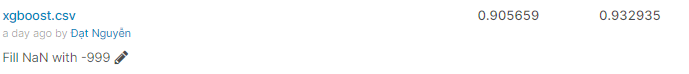

### LightGBM

In [ ]:
%%time
lgbm = lgb.LGBMClassifier(
        boosting_type='gbdt', 
        num_leaves=2**8, 
        max_depth=- 1, 
        learning_rate=0.01,
        n_estimators=800, 
        objective= 'binary', 
        subsample=0.7, 
        subsample_freq=1, 
        colsample_bytree=0.5, 
        n_jobs=- 1, 
)
lgbm.fit(X_train,y_train)

In [ ]:
test_y = lgbm.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,test_y))
print('F1 score:',f1_score(y_test,test_y))
print('Area Under the Receiver Operating Characteristic Curve:',roc_auc_score(y_test,test_y))
print('Confusion maxtrix',confusion_matrix(y_test,test_y))

In [ ]:
metrics.plot_roc_curve(lgbm, X_test, y_test) 

In [ ]:
test_y = lgbm.predict_proba(test)
submission = pd.DataFrame({
    'TransactionID' : sub.TransactionID,
    'isFraud' : test_y[:,1]
})
submission.head()

In [ ]:
submission.to_csv('lgbm.csv',index=False)

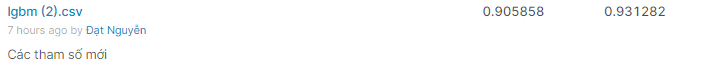

### LightGBM & TimeSeriesSplit

In [ ]:
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.5,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':800,
                    'max_bin':255,
                    'verbose':-1,
                } 

In [ ]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_train, y_train)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[test_idx], label=y_train.iloc[test_idx])
    clf = lgb.train(lgb_params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=100)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

In [ ]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [ ]:
best_iter = clf.best_iteration
clf = lgb.LGBMClassifier(**lgb_params, num_boost_round=best_iter)
clf.fit(X_train, y_train)

In [ ]:
test_y = clf.predict_proba(test)
submission = pd.DataFrame({
    'TransactionID' : sub.TransactionID,
    'isFraud' : test_y[:,1]
})
submission.head()

In [ ]:
submission.to_csv('lgbm_fold.csv',index=False)

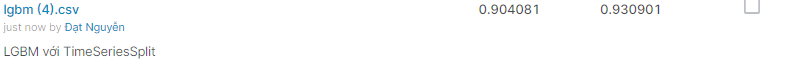

**Nhận xét:**

* 2 thuật toán trên hoạt động tốt đúng như mong đợi.

* LightGBM chạy chậm hơn khá nhiều so với XGBoost

* Kết quả của LGBM ở Private LB cao hơn XGB(0.9058 > 0.9056), nhưng ở Public LB lại thấp hơn (0.9312<0.9329)

* Kết quả của LGBM thấp hơn khi sử dụng TimeSeriesSplit 

##### =>  XGBoost hoạt động tốt hơn so với LightGBM

**Một số phương pháp cải tiến:**
* Loại bỏ bớt các feautures không cần thiết, có thể kết hợp các trường thành 1 features thông quan Features Important
* Sử dụng thêm các phương pháp Fold khác cho LGBM
* Cài đặt các tham số cho thuật toán tốt hơn
* Sử dụng PCA  để giảm số chiều dữ liệu